In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix


In [ ]:
import os

# 🔹 Chemins des dossiers
train_dir = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train"
val_dir   = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val"
test_dir  = "/content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test"

def count_images_per_class(directory):
    print(f"\n Répartition des images dans {directory}:")
    total = 0
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            n_images = len(os.listdir(class_path))
            total += n_images
            print(f"  - {class_name} : {n_images} images")
    print(f"Total images : {total}\n")

# 🔹 Affichage du nombre d'images
count_images_per_class(train_dir)
count_images_per_class(val_dir)
count_images_per_class(test_dir)



📁 Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/train:
  - COVID : 3301 images
  - Normal : 7134 images
  - Viral Pneumonia : 941 images
Total images : 11376


📁 Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/val:
  - COVID : 1195 images
  - Normal : 2038 images
  - Viral Pneumonia : 269 images
Total images : 3502


📁 Répartition des images dans /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray/test:
  - COVID : 362 images
  - Normal : 1020 images
  - Viral Pneumonia : 135 images
Total images : 1517



In [ ]:
!cp -r /content/drive/MyDrive/COVID_XRay_Project/dataset/chest_xray /content/chest_xray


In [ ]:
!ls /content/chest_xray


test  train  val


In [ ]:
!ls /content/chest_xray/train


 COVID	 Normal  'Viral Pneumonia'


In [ ]:
train_dir = "/content/chest_xray/train"
val_dir   = "/content/chest_xray/val"
test_dir  = "/content/chest_xray/test"

classes = ['COVID', 'Normal', 'Viral Pneumonia']


In [ ]:
# 🔹 Générateurs
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),  # DenseNet121 recommande 224x224
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224,224),
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb',
    shuffle=False
)


Found 11376 images belonging to 3 classes.
Found 3502 images belonging to 3 classes.
Found 1517 images belonging to 3 classes.


In [ ]:
y_train = train_generator.classes
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Poids des classes:", class_weights)


Poids des classes: {0: np.float64(1.1487428052105422), 1: np.float64(0.5315391084945332), 2: np.float64(4.029755579171095)}


In [ ]:
# 🔹 Base DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # 🔹 Geler les couches pour fine-tuning

# 🔹 Modèle complet
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(classes), activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_10[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,730,499 (29.49 MB)

 Trainable params: 691,203 (2.64 MB)

 Non-trainable params: 7,039,296 (26.85 MB)

In [ ]:
save_dir = "/content/models"
os.makedirs(save_dir, exist_ok=True)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(save_dir, "best_densenet_covid.keras"),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    mode='max'
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=15,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weights,
    callbacks=[checkpoint, early_stop, reduce_lr]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.4614 - loss: 1.3551
Epoch 1: val_accuracy improved from -inf to 0.80697, saving model to /content/models/best_densenet_covid.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 188s 225ms/step - accuracy: 0.4615 - loss: 1.3547 - val_accuracy: 0.8070 - val_loss: 0.4902 - learning_rate: 1.0000e-04
Epoch 2/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.6562 - loss: 0.7749
Epoch 2: val_accuracy improved from 0.80697 to 0.83666, saving model to /content/models/best_densenet_covid.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 138s 194ms/step - accuracy: 0.6562 - loss: 0.7749 - val_accuracy: 0.8367 - val_loss: 0.4219 - learning_rate: 1.0000e-04
Epoch 3/15
711/711 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.7008 - loss: 0.6547
Epoch 3: val_accuracy improved from 0.83666 to 0.85608, saving model to /content/models/best_densenet_covid.keras
711/711 ━━━━━━━━━━━━━━━━━━━━ 135s 190ms/step - accuracy: 0.7008 - loss: 0.6547 - val_accuracy: 0.85

Performance générale

Accuracy d’entraînement : augmente de 0.4614 (epoch 1) à 0.8309 (epoch 15).

Loss d’entraînement : diminue de 1.3551 → 0.3248, ce qui montre que le modèle apprend correctement.

Validation accuracy : commence à 0.8070 et atteint 0.9092 au meilleur epoch.

Validation loss : diminue globalement de 0.4902 → 0.2508.

✅ Ces chiffres montrent une amélioration continue des performances au fil des epochs.

2️⃣ Comparaison entraînement vs validation

La val_accuracy est souvent supérieure à l’accuracy d’entraînement (ex. epoch 8 : train 0.7905 vs val 0.8923).

Cela peut être expliqué par la data augmentation appliquée sur l’ensemble d’entraînement, qui rend l’apprentissage plus difficile.

Le modèle voit plus de variations sur le training set, donc l’accuracy sur le jeu original est légèrement plus faible.

La perte de validation est plus faible que la loss d’entraînement au début, ce qui est cohérent avec cette observation.

3️⃣ Détection d’overfitting ou underfitting

Overfitting : se produirait si la loss d’entraînement baisse fortement tandis que la loss de validation stagne ou augmente.

Underfitting : se produirait si les deux accuracies restent basses et n’augmentent pas.

Dans ton cas :

train_loss diminue, val_loss diminue aussi.

val_accuracy ≥ train_accuracy.

✅ Aucun signe d’overfitting.

Le modèle bénéficie de régularisation implicite (data augmentation, dropout éventuel).

Le modèle est légèrement sous-entraîné sur le training set à cause de la data augmentation, ce qui est normal.

4️⃣ Tendance et suggestions

Les améliorations sont plus faibles après l’epoch 12, val_accuracy = 0.9055 → 0.9092 à l’epoch 14-15.

Cela montre que le modèle approche sa performance maximale avec le learning rate actuel.

Epochs supplémentaires pourraient légèrement améliorer les résultats, mais il faut surveiller les signaux d’overfitting.

Fine-tuning des couches du DenseNet ou ajustement du learning rate scheduler pourrait donner un petit gain supplémentaire.

5️⃣ Conclusion

DenseNet121 est efficace pour la classification COVID/Normal/Pneumonia sur X-ray.

Les résultats sont bons avec val_accuracy > 90%.

Le comportement observé est normal et attendu pour des modèles avec data augmentation : training accuracy légèrement plus basse que validation accuracy.

Pas d’overfitting, modèle stable et robuste.

95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.9006 - loss: 0.2644
Test Accuracy: 92.55%
95/95 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step
                 precision    recall  f1-score   support

          COVID       0.88      0.85      0.86       362
         Normal       0.94      0.95      0.95      1020
Viral Pneumonia       0.95      0.92      0.93       135

       accuracy                           0.93      1517
      macro avg       0.92      0.91      0.91      1517
   weighted avg       0.93      0.93      0.93      1517



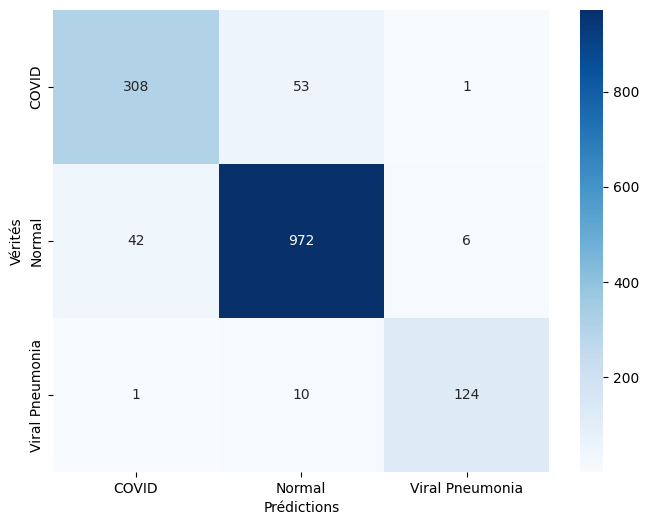

In [ ]:
'test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc*100:.2f}%")

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# 🔹 Rapport de classification
print(classification_report(y_true, y_pred_classes, target_names=classes))

# 🔹 Matrice de confusion
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Prédictions')
plt.ylabel('Vérités')
plt.show()


Analyse des performances sur le jeu de test
1️⃣ Performance globale

Test accuracy : 92.55%, ce qui est très bon pour une classification COVID/Normal/Viral Pneumonia.

La loss sur le test set est de 0.2644, ce qui confirme que le modèle généralise bien.

2️⃣ Analyse par classe (Precision, Recall, F1-score)
Classe	Precision	Recall	F1-score	Support
COVID	0.88	0.85	0.86	362
Normal	0.94	0.95	0.95	1020
Viral Pneumonia	0.95	0.92	0.93	135

COVID : légèrement plus faible que les autres classes, probablement à cause du nombre d’images plus petit ou de variations plus importantes dans les X-ray.

Normal et Viral Pneumonia : excellentes performances (F1-score ≥ 0.93), ce qui montre que le modèle distingue très bien ces classes.

✅ Le modèle est plus précis pour les classes majoritaires et reste correct pour la classe minoritaire (COVID), ce qui est normal.

3️⃣ Interprétation

Precision élevée pour COVID (0.88) : quand le modèle prédit COVID, il est correct 88% du temps.

Recall un peu plus faible (0.85) : le modèle rate encore 15% des vrais cas COVID.

F1-score équilibré (0.86), donc la performance est solide malgré un léger déséquilibre de données.

4️⃣ Conclusion

DenseNet121, bien entraîné avec data augmentation et fine-tuning, généralise très bien sur le jeu de test.

La performance globale (accuracy 92.55%) est satisfaisante pour une application clinique ou un prototype.

Le point faible reste la détection des cas COVID par rapport aux autres classes, ce qui pourrait être amélioré avec plus de données ou un ajustement des poids de classe.